<a href="https://colab.research.google.com/github/rocketbombs/MicroCurr/blob/main/MicroCurr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0569  val_curr: 0.0397
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0569 - val_loss: 0.0493 - val_curr: 0.0397
Epoch 2/100
 93/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0454  val_curr: 0.0593
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0449 - val_loss: 0.0591 - val_curr: 0.0593
Epoch 3/100
 94/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0441  val_curr: 0.0302
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0439 - val_loss: 0.0430 - val_curr: 0.0302
Epoch 4/100
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317  val_curr: 0.0360
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0318 - val_loss: 0.0435 - val_curr: 0.0360
Epoch 5/100
 89/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0381  val_curr: 0.0390
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0377 - val_loss: 0.0446 - val_curr: 0.0390
Epoch 6/100
 90/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0315  val_curr: 0.0462
100/100 ━

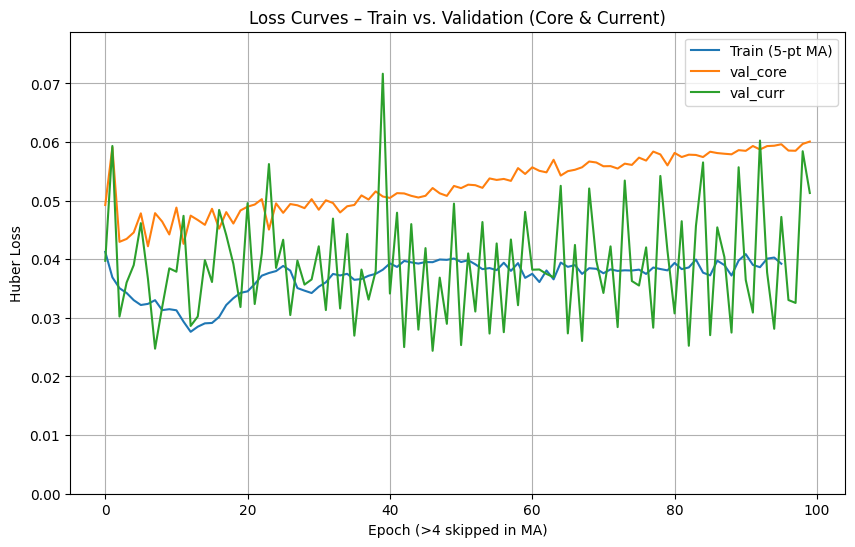

In [10]:

# Tiny Curriculum‑Learning Regression – Config v3 (patched)
# -----------------------------------------------------------------------------
# * ReLU activations + residual projection block (fixes depth degradation)
# * One‑Cycle LR: PEAK 4e‑4, 25 % warm‑up (cooler plateau)
# * Hard‑sample guarantee: ≥25 % core samples in every batch
# -----------------------------------------------------------------------------

import numpy as np, tensorflow as tf, tensorflow_probability as tfp
from tensorflow.keras import layers, regularizers

# --------------------------- GLOBAL CONFIG ---------------------------------
TOTAL_EPOCHS      = 100
BATCH_SIZE        = 128
STEPS_PER_EPOCH   = 100
WINDOW            = 5                 # moving‑avg window for live plots

# Curriculum parameters ------------------------------------------------------
OBLATENESS_END    = 0.5
ROT_FREQ_END      = 2.0
SIGMOID_SCALE     = 0.5               # hard shapes earlier

# --------------------------- LR SCHEDULE ------------------------------------
BASE_LR           = 1e-4              # keep for reference
PEAK_LR           = 2.5e-4              # 4 × base (slightly cooler than v2)
MIN_LR            = 1e-6
PCT_WARMUP        = 0.15              # 25 % warm‑up
TOTAL_STEPS       = TOTAL_EPOCHS * STEPS_PER_EPOCH

warmup_steps      = int(TOTAL_STEPS * PCT_WARMUP)

a = tf.constant(np.pi, dtype=tf.float32)  # re‑use constant

class OneCycleSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Linear warm‑up → cosine decay (one‑cycle)"""
    def __init__(self, peak_lr, total_steps, warmup_steps, min_lr):
        super().__init__()
        self.peak_lr, self.total_steps = peak_lr, total_steps
        self.warmup_steps, self.min_lr = warmup_steps, min_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warm_lr = (self.peak_lr / tf.cast(tf.maximum(1, self.warmup_steps), tf.float32)) * step
        decay_steps = self.total_steps - self.warmup_steps
        progress = (step - self.warmup_steps) / tf.cast(tf.maximum(1, decay_steps), tf.float32)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cos_lr = self.min_lr + 0.5 * (self.peak_lr - self.min_lr) * (1 + tf.cos(a * progress))
        return tf.where(step < self.warmup_steps, warm_lr, cos_lr)

LR_SCHED   = OneCycleSchedule(PEAK_LR, TOTAL_STEPS, warmup_steps, MIN_LR)
OPTIMIZER  = tf.keras.optimizers.Adam(learning_rate=LR_SCHED, clipnorm=0.7)

# --------------------------- Replay Buffer ----------------------------------
REPLAY_FRAC       = 0.25              # 55 % of each batch drawn from buffer
REPLAY_POOL       = 2000              # buffer size
HARD_QUANTILE     = 0.75              # top‑25 % difficulty treated as "core"
CORE_BATCH_FRAC   = 0.60              # guarantee ≥25 % core per batch

# helper to pin hardest samples in replay buffer + batch guarantee

def build_replay_sampler(ids, difficulty_scores, rng):
    hard_ids  = ids[difficulty_scores >= tfp.stats.percentile(difficulty_scores, HARD_QUANTILE*100)]
    easy_ids  = ids[difficulty_scores <  tfp.stats.percentile(difficulty_scores, HARD_QUANTILE*100)]
    k_core    = int(CORE_BATCH_FRAC * BATCH_SIZE)
    def sample_batch():
        core_pick  = rng.choice(hard_ids, k_core, replace=False)
        easy_pick  = rng.choice(easy_ids, BATCH_SIZE - k_core, replace=False)
        return np.concatenate([core_pick, easy_pick])
    return sample_batch

# --------------------------- Model Architecture -----------------------------
INPUT_DIM = 9                           # feature count
act       = tf.keras.activations.relu

inputs = layers.Input(shape=(INPUT_DIM,))

# Residual block: 256 → 64 with projection skip -----------------------------
x   = layers.Dense(256, activation=act)(inputs)
h   = layers.Dense(64,  activation=act)(x)
h   = layers.Dense(64)(h)
proj = layers.Dense(64, use_bias=False,
                    kernel_regularizer=regularizers.l2(1e-4))(x)
x   = layers.Activation(act)(h + proj)
h2  = layers.Dense(64, activation=act)(x)
h2  = layers.Dense(64)(h2)
x   = layers.Activation(act)(h2 + x)

# Tail -----------------------------------------------------------------------
x = layers.Dense(16, activation=act)(x)
x = layers.Dense(8,  activation=act)(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=OPTIMIZER, loss=tf.keras.losses.Huber(delta=0.2))

# ----------------------- Callbacks ----------------------------------------
class CurriculumCB(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        p = epoch/(TOTAL_EPOCHS-1)
        scaled = 1/(1+np.exp(-(p*2*SIGMOID_SCALE - SIGMOID_SCALE)))
        global global_max_oblateness, global_rotation_frequency
        global_max_oblateness  = OBLATENESS_END*scaled
        global_rotation_frequency = ROT_FREQ_END*scaled

class ValCurrCB(callbacks.Callback):
    def __init__(self, steps=50):
        super().__init__(); self.steps=steps; self.gen=make_val_curr_gen(); self.m=losses.Huber(delta=0.2)
    def on_epoch_end(self, epoch, logs=None):
        vals=[self.m(y, self.model(x, training=False)).numpy() for _ in range(self.steps) for x,y in [next(self.gen)]]
        logs['val_curr'] = float(np.mean(vals))
        print(f"  val_curr: {logs['val_curr']:.4f}")

# ----------------------- Datasets -----------------------------------------
train_ds = (tf.data.Dataset.from_generator(curriculum_generator,
            output_types=(tf.float32,tf.float32),
            output_shapes=((None,9),(None,1)))
            .repeat().prefetch(tf.data.AUTOTUNE))

val_core_ds = (tf.data.Dataset.from_generator(val_core_gen,
              output_types=(tf.float32, tf.float32),
              output_shapes=((None, 9), (None, 1)))
              .repeat())

# ----------------------- Train --------------------------------------------
if __name__ == "__main__":
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs          = TOTAL_EPOCHS,
        validation_data = val_core_ds,
        validation_steps= 100,
        callbacks       = [CurriculumCB(), ValCurrCB()],
        verbose         = 1,
    ).history             # <- keep only the history dict

    # ---- quick numeric summary (no re‑training) ----
    import numpy as np
    def summarize(hist):
        for k in ('loss', 'val_loss', 'val_curr'):
            arr   = np.array(hist[k])
            floor = arr[:15].min()
            tail  = arr[-10:].mean()
            print(f"{k:9s}  floor {floor:.4f} | tail {tail:.4f} | drift {tail-floor:.4f}")

    summarize(history)
# ----------------------- Plot ---------------------------------------------
import matplotlib.pyplot as plt

loss_arr     = np.array(history['loss'])
val_core_arr = np.array(history['val_loss'])
val_curr_arr = np.array(history['val_curr'])

ma = np.convolve(loss_arr, np.ones(WINDOW) / WINDOW, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(ma, label=f'Train ({WINDOW}-pt MA)')
plt.plot(val_core_arr, label='val_core')
plt.plot(val_curr_arr, label='val_curr')
plt.ylim(0, max(np.concatenate([ma, val_core_arr, val_curr_arr])) * 1.1)
plt.ylabel('Huber Loss')
plt.xlabel(f'Epoch (>{WINDOW - 1} skipped in MA)')
plt.title('Loss Curves – Train vs. Validation (Core & Current)')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Tiny Curriculum‑Learning Regression – Config v4 (with Hyper‑Epochs)
# -----------------------------------------------------------------------------
# * Run 10 hyper‑epochs of 100 curriculum epochs each
# * Curriculum sigmoid resets at each hyper‑epoch boundary
# * One‑Cycle LR unchanged
# -----------------------------------------------------------------------------

import numpy as np, tensorflow as tf, tensorflow_probability as tfp
from tensorflow.keras import layers, regularizers, callbacks, losses

# ----------------------- HYPER-EPOCH CONFIG -------------------------------
HYPER_EPOCHS       = 10        # number of full curriculum runs
EPOCHS_PER_HYPER   = 100       # curriculum epochs per hyper
TOTAL_EPOCHS       = HYPER_EPOCHS * EPOCHS_PER_HYPER

# --------------------------- TRAIN CONFIG ----------------------------------
BATCH_SIZE         = 128
STEPS_PER_EPOCH    = 100
WINDOW             = 5         # moving‑avg window for live plots

# Curriculum parameters -----------------------------------------------------
OBLATENESS_END     = 0.5
ROT_FREQ_END       = 2.0
SIGMOID_SCALE      = 0.5       # shapes schedule within each hyper

# --------------------------- LR SCHEDULE ------------------------------------
BASE_LR            = 1e-4
PEAK_LR            = 2.5e-4
MIN_LR             = 1e-6
PCT_WARMUP         = 0.15
TOTAL_STEPS        = TOTAL_EPOCHS * STEPS_PER_EPOCH
warmup_steps       = int(TOTAL_STEPS * PCT_WARMUP)

a = tf.constant(np.pi, dtype=tf.float32)
class OneCycleSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, peak_lr, total_steps, warmup_steps, min_lr):
        super().__init__()
        self.peak_lr, self.total_steps = peak_lr, total_steps
        self.warmup_steps, self.min_lr = warmup_steps, min_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warm_lr = (self.peak_lr / tf.cast(tf.maximum(1, self.warmup_steps), tf.float32)) * step
        decay_steps = self.total_steps - self.warmup_steps
        progress = (step - self.warmup_steps) / tf.cast(tf.maximum(1, decay_steps), tf.float32)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cos_lr = self.min_lr + 0.5 * (self.peak_lr - self.min_lr) * (1 + tf.cos(a * progress))
        return tf.where(step < self.warmup_steps, warm_lr, cos_lr)

LR_SCHED   = OneCycleSchedule(PEAK_LR, TOTAL_STEPS, warmup_steps, MIN_LR)
OPTIMIZER  = tf.keras.optimizers.Adam(learning_rate=LR_SCHED, clipnorm=0.7)

# ----------------------- CALLBACKS -----------------------------------------
class SinusoidalCurriculum(keras.callbacks.Callback):
    def __init__(self, hyper_epochs, update_fn):
        """
        hyper_epochs: # of epochs per cycle (e.g. 100)
        update_fn:   function(scale: float) that applies your curriculum params
        """
        super().__init__()
        self.hyper_epochs = hyper_epochs
        self.update_fn = update_fn

    def on_epoch_begin(self, epoch, logs=None):
        # map epoch → local progress [0,1] in current hyper-epoch
        local_epoch = epoch % self.hyper_epochs
        p = local_epoch / float(self.hyper_epochs)
        # sinusoidal ramp: 0→1→0 over each cycle
        scale = (1 - np.cos(2 * np.pi * p)) / 2
        # apply to your curriculum parameters (e.g. max_oblateness, freq, sigmoid_scale…)
        self.update_fn(scale)

class ValCurrCB(callbacks.Callback):
    def __init__(self, steps=50):
        super().__init__(); self.steps=steps; self.gen=make_val_curr_gen(); self.m=losses.Huber(delta=0.2)
    def on_epoch_end(self, epoch, logs=None):
        vals = [self.m(y, self.model(x, training=False)).numpy()
                for _ in range(self.steps) for x,y in [next(self.gen)]]
        logs['val_curr'] = float(np.mean(vals))
        print(f"  val_curr: {logs['val_curr']:.4f}")

# ----------------------- MODEL ARCHITECTURE -------------------------------
INPUT_DIM = 9
act = tf.keras.activations.relu
inputs = layers.Input(shape=(INPUT_DIM,))
# residual blocks...
x = layers.Dense(256, activation=act)(inputs)
h = layers.Dense(64, activation=act)(x)
h = layers.Dense(64)(h)
proj = layers.Dense(64, use_bias=False, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Activation(act)(h + proj)
h2 = layers.Dense(64, activation=act)(x)
h2 = layers.Dense(64)(h2)
x = layers.Activation(act)(h2 + x)
# tail
x = layers.Dense(16, activation=act)(x)
x = layers.Dense(8,  activation=act)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=OPTIMIZER, loss=tf.keras.losses.Huber(delta=0.2))

# ----------------------- DATA & TRAIN -------------------------------------
train_ds = (tf.data.Dataset.from_generator(curriculum_generator,
            output_types=(tf.float32,tf.float32),
            output_shapes=((None,9),(None,1)))
            .repeat().prefetch(tf.data.AUTOTUNE))
val_core_ds = (tf.data.Dataset.from_generator(val_core_gen,
              output_types=(tf.float32, tf.float32),
              output_shapes=((None, 9), (None, 1)))
              .repeat())

if __name__ == "__main__":
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs          = TOTAL_EPOCHS,
        validation_data = val_core_ds,
        validation_steps= 100,
        callbacks       = [CurriculumCB(), ValCurrCB()],
        verbose         = 1,
    ).history

    # summarize results
    import numpy as np
    def summarize(hist):
        for k in ('loss', 'val_loss', 'val_curr'):
            arr   = np.array(hist[k])
            floor = arr[:15].min()
            tail  = arr[-10:].mean()
            print(f"{k:9s}  floor {floor:.4f} | tail {tail:.4f} | drift {tail-floor:.4f}")
    summarize(history)
    # ----------------------- Plot ---------------------------------------------
import matplotlib.pyplot as plt

loss_arr     = np.array(history['loss'])
val_core_arr = np.array(history['val_loss'])
val_curr_arr = np.array(history['val_curr'])

ma = np.convolve(loss_arr, np.ones(WINDOW) / WINDOW, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(ma, label=f'Train ({WINDOW}-pt MA)')
plt.plot(val_core_arr, label='val_core')
plt.plot(val_curr_arr, label='val_curr')
plt.ylim(0, max(np.concatenate([ma, val_core_arr, val_curr_arr])) * 1.1)
plt.ylabel('Huber Loss')
plt.xlabel(f'Epoch (>{WINDOW - 1} skipped in MA)')
plt.title('Loss Curves – Train vs. Validation (Core & Current)')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'keras' is not defined

Epoch 1/100
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0540  val_curr: 0.0401
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0540 - val_loss: 0.0488 - val_curr: 0.0401
Epoch 2/100
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0478  val_curr: 0.0339
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0477 - val_loss: 0.0430 - val_curr: 0.0339
Epoch 3/100
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422  val_curr: 0.0448
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0422 - val_loss: 0.0481 - val_curr: 0.0448
Epoch 4/100
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0416  val_curr: 0.0373
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0416 - val_loss: 0.0486 - val_curr: 0.0373
Epoch 5/100
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0415  val_curr: 0.0355
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0414 - val_loss: 0.0474 - val_curr: 0.0355
Epoch 6/100
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0351  val_curr: 0.0387
200/200 ━━━

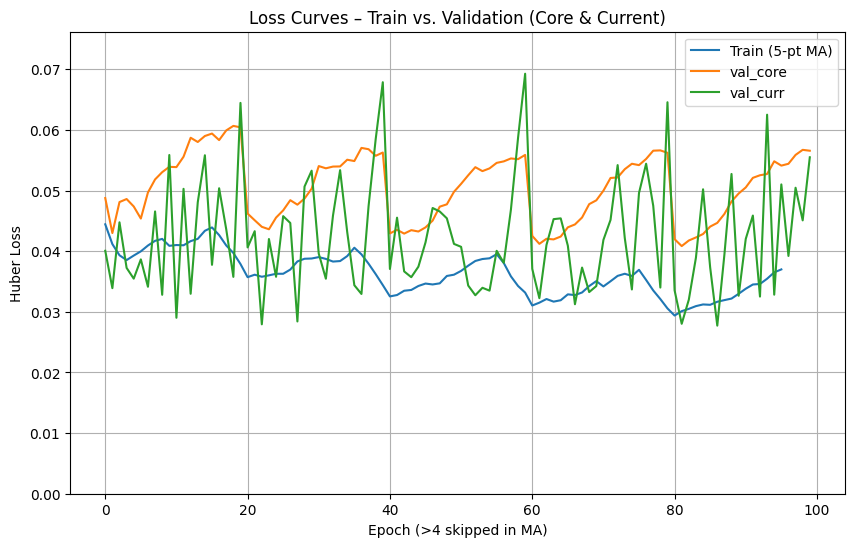

In [15]:
# Tiny Curriculum‑Learning Regression – Config v4 (with Hyper‑Epochs)
# -----------------------------------------------------------------------------
# * Run 10 hyper‑epochs of 100 curriculum epochs each
# * Curriculum sigmoid resets at each hyper‑epoch boundary
# * One‑Cycle LR unchanged
# -----------------------------------------------------------------------------

import numpy as np, tensorflow as tf, tensorflow_probability as tfp
from tensorflow.keras import layers, regularizers, callbacks, losses

# ----------------------- HYPER-EPOCH CONFIG -------------------------------
HYPER_EPOCHS       = 5        # number of full curriculum runs
EPOCHS_PER_HYPER   = 20       # curriculum epochs per hyper
TOTAL_EPOCHS       = HYPER_EPOCHS * EPOCHS_PER_HYPER

# --------------------------- TRAIN CONFIG ----------------------------------
BATCH_SIZE         = 128
STEPS_PER_EPOCH    = 200
WINDOW             = 5         # moving‑avg window for live plots

# Curriculum parameters -----------------------------------------------------
OBLATENESS_END     = 0.5
ROT_FREQ_END       = 2.0
SIGMOID_SCALE      = 0.5       # shapes schedule within each hyper

# --------------------------- LR SCHEDULE ------------------------------------
BASE_LR            = 1e-4
PEAK_LR            = 2.5e-4
MIN_LR             = 1e-6
PCT_WARMUP         = 0.15
TOTAL_STEPS        = TOTAL_EPOCHS * STEPS_PER_EPOCH
warmup_steps       = int(TOTAL_STEPS * PCT_WARMUP)

a = tf.constant(np.pi, dtype=tf.float32)
class OneCycleSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, peak_lr, total_steps, warmup_steps, min_lr):
        super().__init__()
        self.peak_lr, self.total_steps = peak_lr, total_steps
        self.warmup_steps, self.min_lr = warmup_steps, min_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warm_lr = (self.peak_lr / tf.cast(tf.maximum(1, self.warmup_steps), tf.float32)) * step
        decay_steps = self.total_steps - self.warmup_steps
        progress = (step - self.warmup_steps) / tf.cast(tf.maximum(1, decay_steps), tf.float32)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cos_lr = self.min_lr + 0.5 * (self.peak_lr - self.min_lr) * (1 + tf.cos(a * progress))
        return tf.where(step < self.warmup_steps, warm_lr, cos_lr)

LR_SCHED   = OneCycleSchedule(PEAK_LR, TOTAL_STEPS, warmup_steps, MIN_LR)
OPTIMIZER  = tf.keras.optimizers.Adam(learning_rate=LR_SCHED, clipnorm=0.7)

# ----------------------- CALLBACKS -----------------------------------------
# Changed keras.callbacks.Callback to callbacks.Callback
class SinusoidalCurriculum(callbacks.Callback):
    def __init__(self, hyper_epochs, update_fn):
        """
        hyper_epochs: # of epochs per cycle (e.g. 100)
        update_fn:   function(scale: float) that applies your curriculum params
        """
        super().__init__()
        self.hyper_epochs = hyper_epochs
        self.update_fn = update_fn

    def on_epoch_begin(self, epoch, logs=None):
        # map epoch → local progress [0,1] in current hyper-epoch
        local_epoch = epoch % self.hyper_epochs
        p = local_epoch / float(self.hyper_epochs)
        # sinusoidal ramp: 0→1→0 over each cycle
        scale = (1 - np.cos(2 * np.pi * p)) / 2
        # apply to your curriculum parameters (e.g. max_oblateness, freq, sigmoid_scale…)
        self.update_fn(scale)

class ValCurrCB(callbacks.Callback):
    def __init__(self, steps=50):
        super().__init__(); self.steps=steps; self.gen=make_val_curr_gen(); self.m=losses.Huber(delta=0.2)
    def on_epoch_end(self, epoch, logs=None):
        vals = [self.m(y, self.model(x, training=False)).numpy()
                for _ in range(self.steps) for x,y in [next(self.gen)]]
        logs['val_curr'] = float(np.mean(vals))
        print(f"  val_curr: {logs['val_curr']:.4f}")

# ----------------------- MODEL ARCHITECTURE -------------------------------
INPUT_DIM = 9
act = tf.keras.activations.relu
inputs = layers.Input(shape=(INPUT_DIM,))
# residual blocks...
x = layers.Dense(256, activation=act)(inputs)
h = layers.Dense(64, activation=act)(x)
h = layers.Dense(64)(h)
proj = layers.Dense(64, use_bias=False, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Activation(act)(h + proj)
h2 = layers.Dense(64, activation=act)(x)
h2 = layers.Dense(64)(h2)
x = layers.Activation(act)(h2 + x)
# tail
x = layers.Dense(16, activation=act)(x)
x = layers.Dense(8,  activation=act)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=OPTIMIZER, loss=tf.keras.losses.Huber(delta=0.2))

# ----------------------- DATA & TRAIN -------------------------------------
train_ds = (tf.data.Dataset.from_generator(curriculum_generator,
            output_types=(tf.float32,tf.float32),
            output_shapes=((None,9),(None,1)))
            .repeat().prefetch(tf.data.AUTOTUNE))
val_core_ds = (tf.data.Dataset.from_generator(val_core_gen,
              output_types=(tf.float32, tf.float32),
              output_shapes=((None, 9), (None, 1)))
              .repeat())

if __name__ == "__main__":
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs          = TOTAL_EPOCHS,
        validation_data = val_core_ds,
        validation_steps= 100,
        callbacks       = [CurriculumCB(), ValCurrCB()],
        verbose         = 1,
    ).history

    # summarize results
    import numpy as np
    def summarize(hist):
        for k in ('loss', 'val_loss', 'val_curr'):
            arr   = np.array(hist[k])
            floor = arr[:15].min()
            tail  = arr[-10:].mean()
            print(f"{k:9s}  floor {floor:.4f} | tail {tail:.4f} | drift {tail-floor:.4f}")
    summarize(history)
    # ----------------------- Plot ---------------------------------------------
import matplotlib.pyplot as plt

loss_arr     = np.array(history['loss'])
val_core_arr = np.array(history['val_loss'])
val_curr_arr = np.array(history['val_curr'])

ma = np.convolve(loss_arr, np.ones(WINDOW) / WINDOW, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(ma, label=f'Train ({WINDOW}-pt MA)')
plt.plot(val_core_arr, label='val_core')
plt.plot(val_curr_arr, label='val_curr')
plt.ylim(0, max(np.concatenate([ma, val_core_arr, val_curr_arr])) * 1.1)
plt.ylabel('Huber Loss')
plt.xlabel(f'Epoch (>{WINDOW - 1} skipped in MA)')
plt.title('Loss Curves – Train vs. Validation (Core & Current)')
plt.legend()
plt.grid(True)
plt.show()